In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Bidirectional, SimpleRNN

seed =1234

In [3]:
df = pd.read_csv('./kospi.csv')
df.set_index('Date', inplace=True)
df.shape

(4522, 6)

In [4]:
df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2003-07-29,722.33,718.42,722.47,715.01,566860000.0,0.0063
2003-07-30,714.15,721.66,724.23,714.07,502180000.0,-0.0113
2003-07-31,713.52,716.50,718.49,710.01,388890000.0,-0.0009
2003-08-01,727.26,718.84,728.38,718.25,457000000.0,0.0193
2003-08-04,718.54,719.57,724.17,717.46,439400000.0,-0.0120


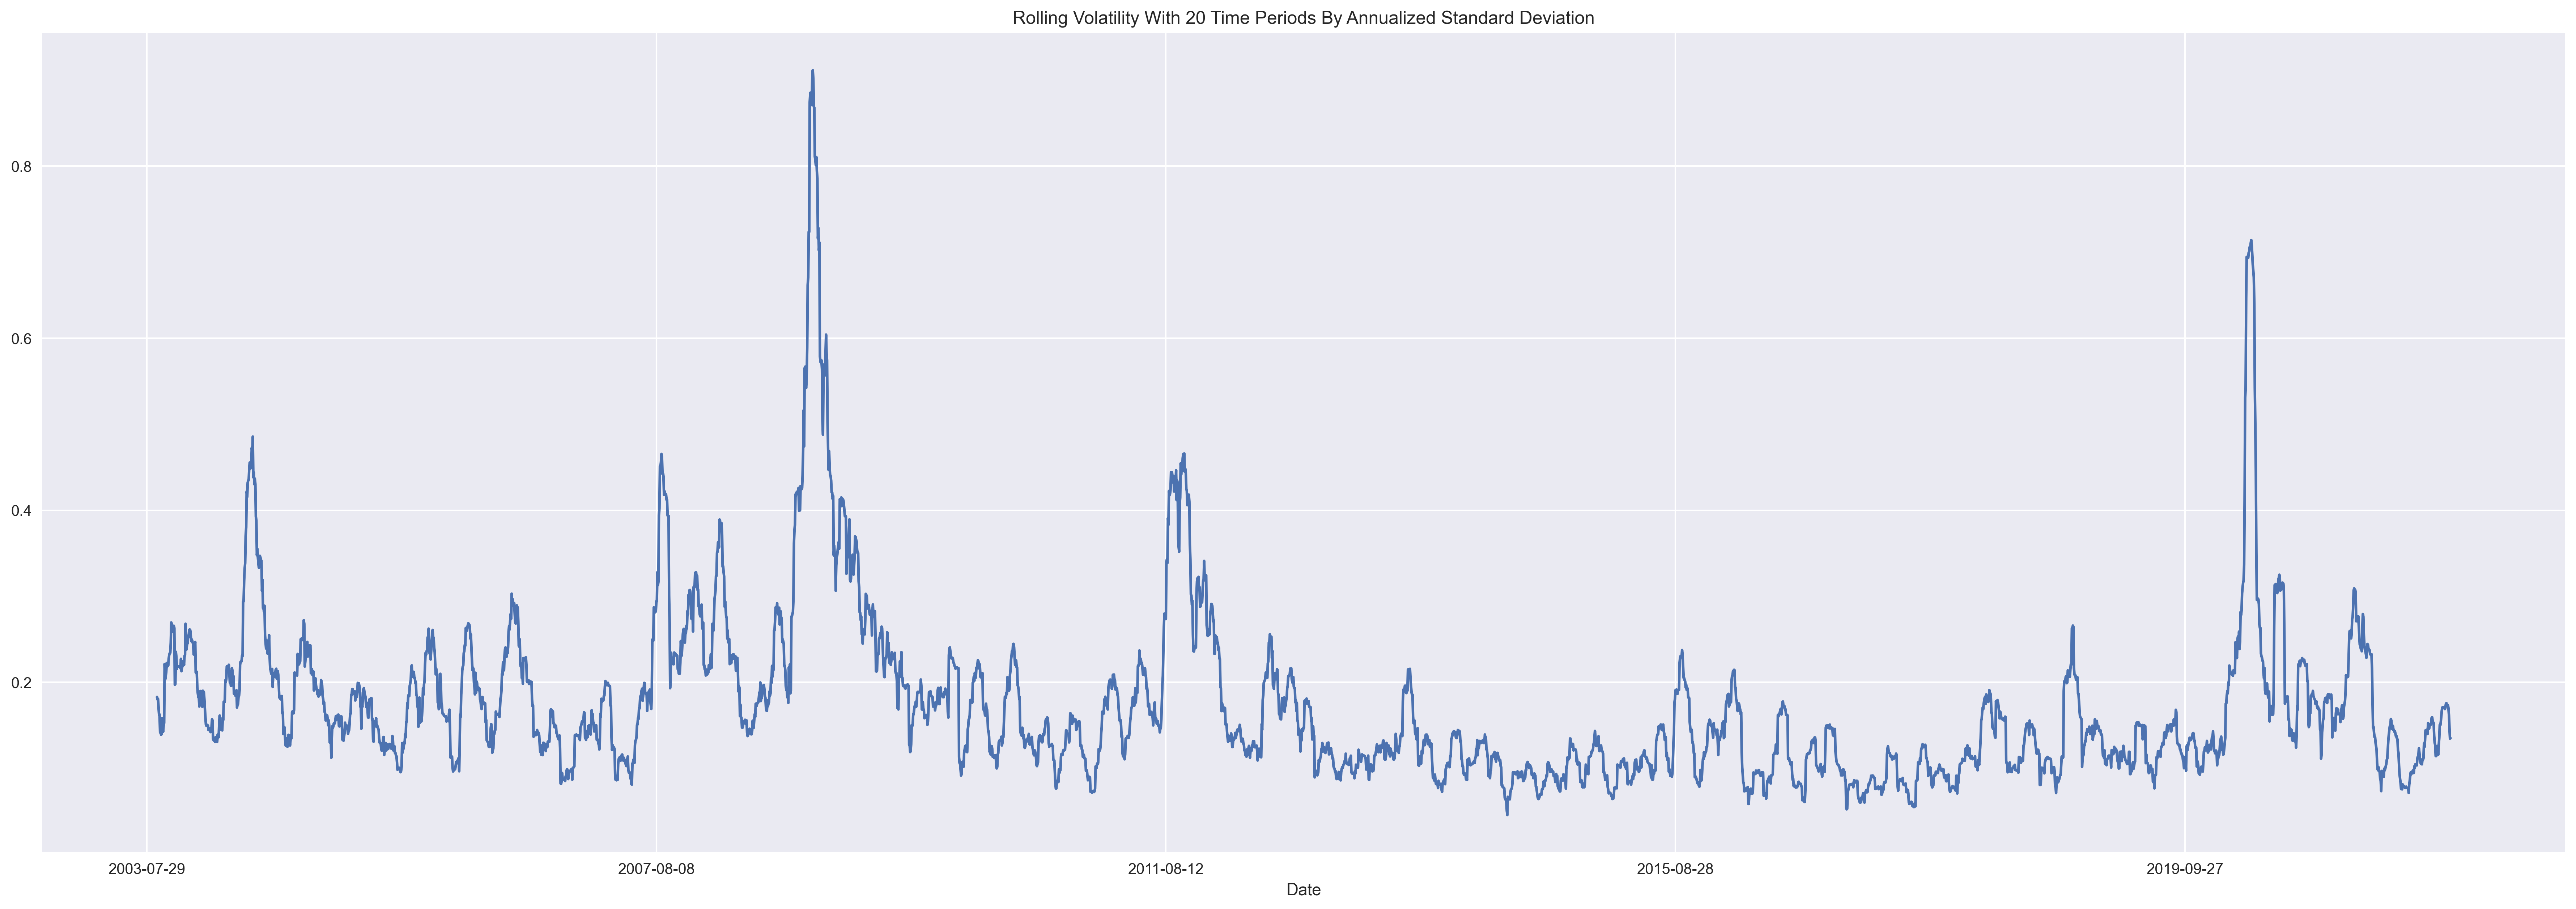

In [5]:
df['Change']    = df['Close'].pct_change()
df['STDEV']     = df['Close'].rolling(window=20).std(ddof=0)
df['STDEV_log'] = np.log(df['Close'].rolling(window=20).std(ddof=0))
df['HV']        = df['Change'].rolling(window=20, center=False).std() * (252 ** 0.5)

df['HV'].plot(figsize=(30, 10))
plt.title('Rolling Volatility With 20 Time Periods By Annualized Standard Deviation')
plt.show()

In [6]:
feature_df = df.loc['2003-09-29':'2021-09-28', 'STDEV':'HV']
print(feature_df.shape)
feature_df

(4455, 3)


,STDEV,STDEV_log,HV
Date,,,
2003-09-29,24.124477,3.183227,0.218297
2003-09-30,26.250180,3.267673,0.218889
2003-10-01,27.269905,3.305784,0.219563
2003-10-02,27.224550,3.304119,0.227551
2003-10-06,26.583630,3.280296,0.232149
...,...,...,...
2021-09-17,32.004801,3.465886,0.129747
2021-09-23,29.257307,3.376129,0.127155
2021-09-24,29.761254,3.393207,0.114283


In [7]:
label_df = df.loc['2003-09-29':'2021-09-28', 'HV']
print(label_df.shape)
label_df

(4455,)


Date
2003-09-29    0.218297
2003-09-30    0.218889
2003-10-01    0.219563
2003-10-02    0.227551
2003-10-06    0.232149
                ...   
2021-09-17    0.129747
2021-09-23    0.127155
2021-09-24    0.114283
2021-09-27    0.114275
2021-09-28    0.119526
Name: HV, Length: 4455, dtype: float64

# TRAIN, TEST 분리

In [8]:
X = feature_df
y = label_df

In [9]:
# '2019-09-29' 기준으로 나눌 것이다.
# 225+ 252 = 477
# split = -477
X_train = X.loc['2003-09-29':'2019-09-28']
y_train = y.loc['2003-09-29':'2019-09-28']

X_test = X.loc['2019-09-29':'2021-09-28']
y_test = y.loc['2019-09-29':'2021-09-28']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3961, 3) (3961,)
(494, 3) (494,)


In [10]:
X_train  # 2019년 9월 27일(금요알)

,STDEV,STDEV_log,HV
Date,,,
2003-09-29,24.124477,3.183227,0.218297
2003-09-30,26.250180,3.267673,0.218889
2003-10-01,27.269905,3.305784,0.219563
2003-10-02,27.224550,3.304119,0.227551
2003-10-06,26.583630,3.280296,0.232149
...,...,...,...
2019-09-23,57.303941,4.048369,0.109427
2019-09-24,59.195565,4.080847,0.107913
2019-09-25,56.041691,4.026096,0.100154


In [11]:
X_test # 2019.9.30(월)

,STDEV,STDEV_log,HV
Date,,,
2019-09-30,42.824801,3.757117,0.111092
2019-10-01,39.805411,3.684003,0.097235
2019-10-02,35.861176,3.579655,0.125088
2019-10-04,31.106999,3.437433,0.127118
2019-10-07,28.421484,3.347145,0.121267
...,...,...,...
2021-09-17,32.004801,3.465886,0.129747
2021-09-23,29.257307,3.376129,0.127155
2021-09-24,29.761254,3.393207,0.114283


In [12]:
# 딥러닝 학습을 위해 df -> numpy 변환
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

In [13]:
# 입력 파라미터 feature, label -> numpy type

def make_sequence_dataset(feature, label, window_size):
    feature_list = [] # 생성될 feature list
    label_list = []  # 생성될 label list
    
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
    return np.array(feature_list), np.array(label_list) # 3차원으로 만들어줌

In [14]:
window_size = 20
X_train, y_train = make_sequence_dataset(X_train_np, y_train_np, window_size)
X_test, y_test = make_sequence_dataset(X_test_np, y_test_np, window_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # (batch size, time steps, input dims)

(3941, 20, 3) (3941,) (474, 20, 3) (474,)


# TRAIN, TEST 분리

In [15]:
# input_shape
X_train[0].shape

(20, 3)

# Model

In [16]:
# https://www.tensorflow.org/guide/keras/rnn?hl=ko

In [17]:
model = Sequential()
model.add(GRU(256, return_sequences=True, activation = 'relu', input_shape = X_train[0].shape)) 
model.add(SimpleRNN(128, activation = 'relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20, 256)           200448    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 249,857
Trainable params: 249,857
Non-trainable params: 0
_________________________________________________________________


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss = 'mse', optimizer = 'adam')
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, 
          batch_size=60, callbacks = [early_stop])

Epoch 1/100
66/66 [==============================] - 11s 144ms/step - loss: 0.1175 - val_loss: 0.0238
Epoch 2/100
66/66 [==============================] - 9s 144ms/step - loss: 0.0046 - val_loss: 0.0383
Epoch 3/100
66/66 [==============================] - 9s 141ms/step - loss: 0.0039 - val_loss: 0.0169
Epoch 4/100
66/66 [==============================] - 9s 138ms/step - loss: 0.0045 - val_loss: 0.0175
Epoch 5/100
66/66 [==============================] - 10s 149ms/step - loss: 0.0037 - val_loss: 0.0144
Epoch 6/100
66/66 [==============================] - 10s 157ms/step - loss: 0.0039 - val_loss: 0.0166
Epoch 7/100
66/66 [==============================] - 11s 174ms/step - loss: 0.0031 - val_loss: 0.0155
Epoch 8/100
66/66 [==============================] - 11s 173ms/step - loss: 0.0034 - val_loss: 0.0114
Epoch 9/100
66/66 [==============================] - 12s 176ms/step - loss: 0.0028 - val_loss: 0.0056
Epoch 10/100
66/66 [==============================] - 11s 167ms/step - loss: 0.0023 -

In [19]:
val_loss = history.history['val_loss']
print(val_loss[:5])

[0.02375539392232895, 0.038259025663137436, 0.016888320446014404, 0.017519891262054443, 0.014444421976804733]


In [20]:
train_loss = history.history['loss']
print(train_loss[:5])

[0.11747884005308151, 0.004639321006834507, 0.003947536461055279, 0.004496042151004076, 0.003664706600829959]


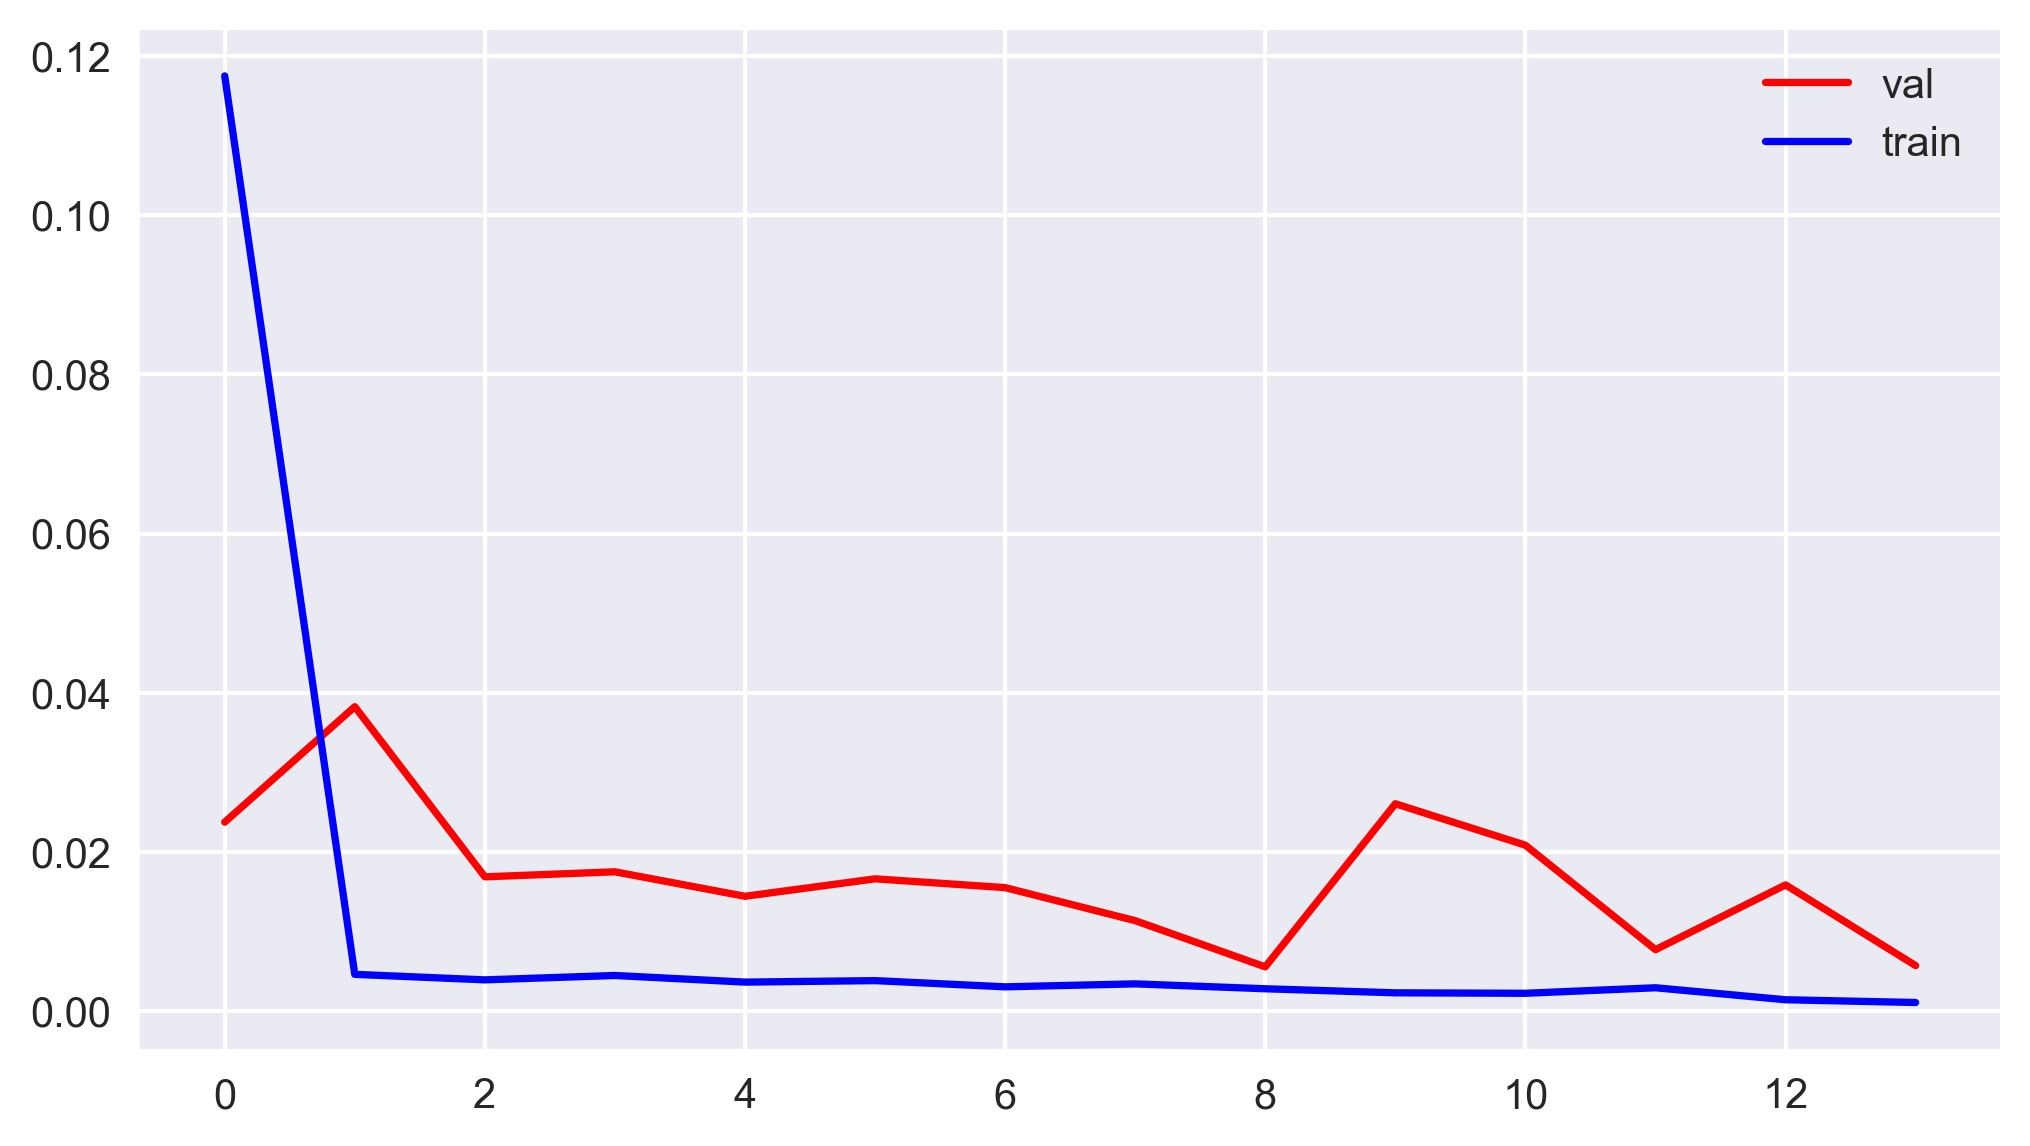

In [21]:
plt.plot(np.arange(len(val_loss)), val_loss, c="red", label='val')
plt.plot(np.arange(len(train_loss)), train_loss, c='blue', label ='train')
plt.legend()
plt.show()

# 예측 결과 시각화
- https://www.youtube.com/watch?v=LLLVYkXJw30

In [22]:
pred = model.predict(X_test)

In [23]:
score_rmse = np.sqrt(np.min(val_loss))
score_rmse

0.07468554243810362

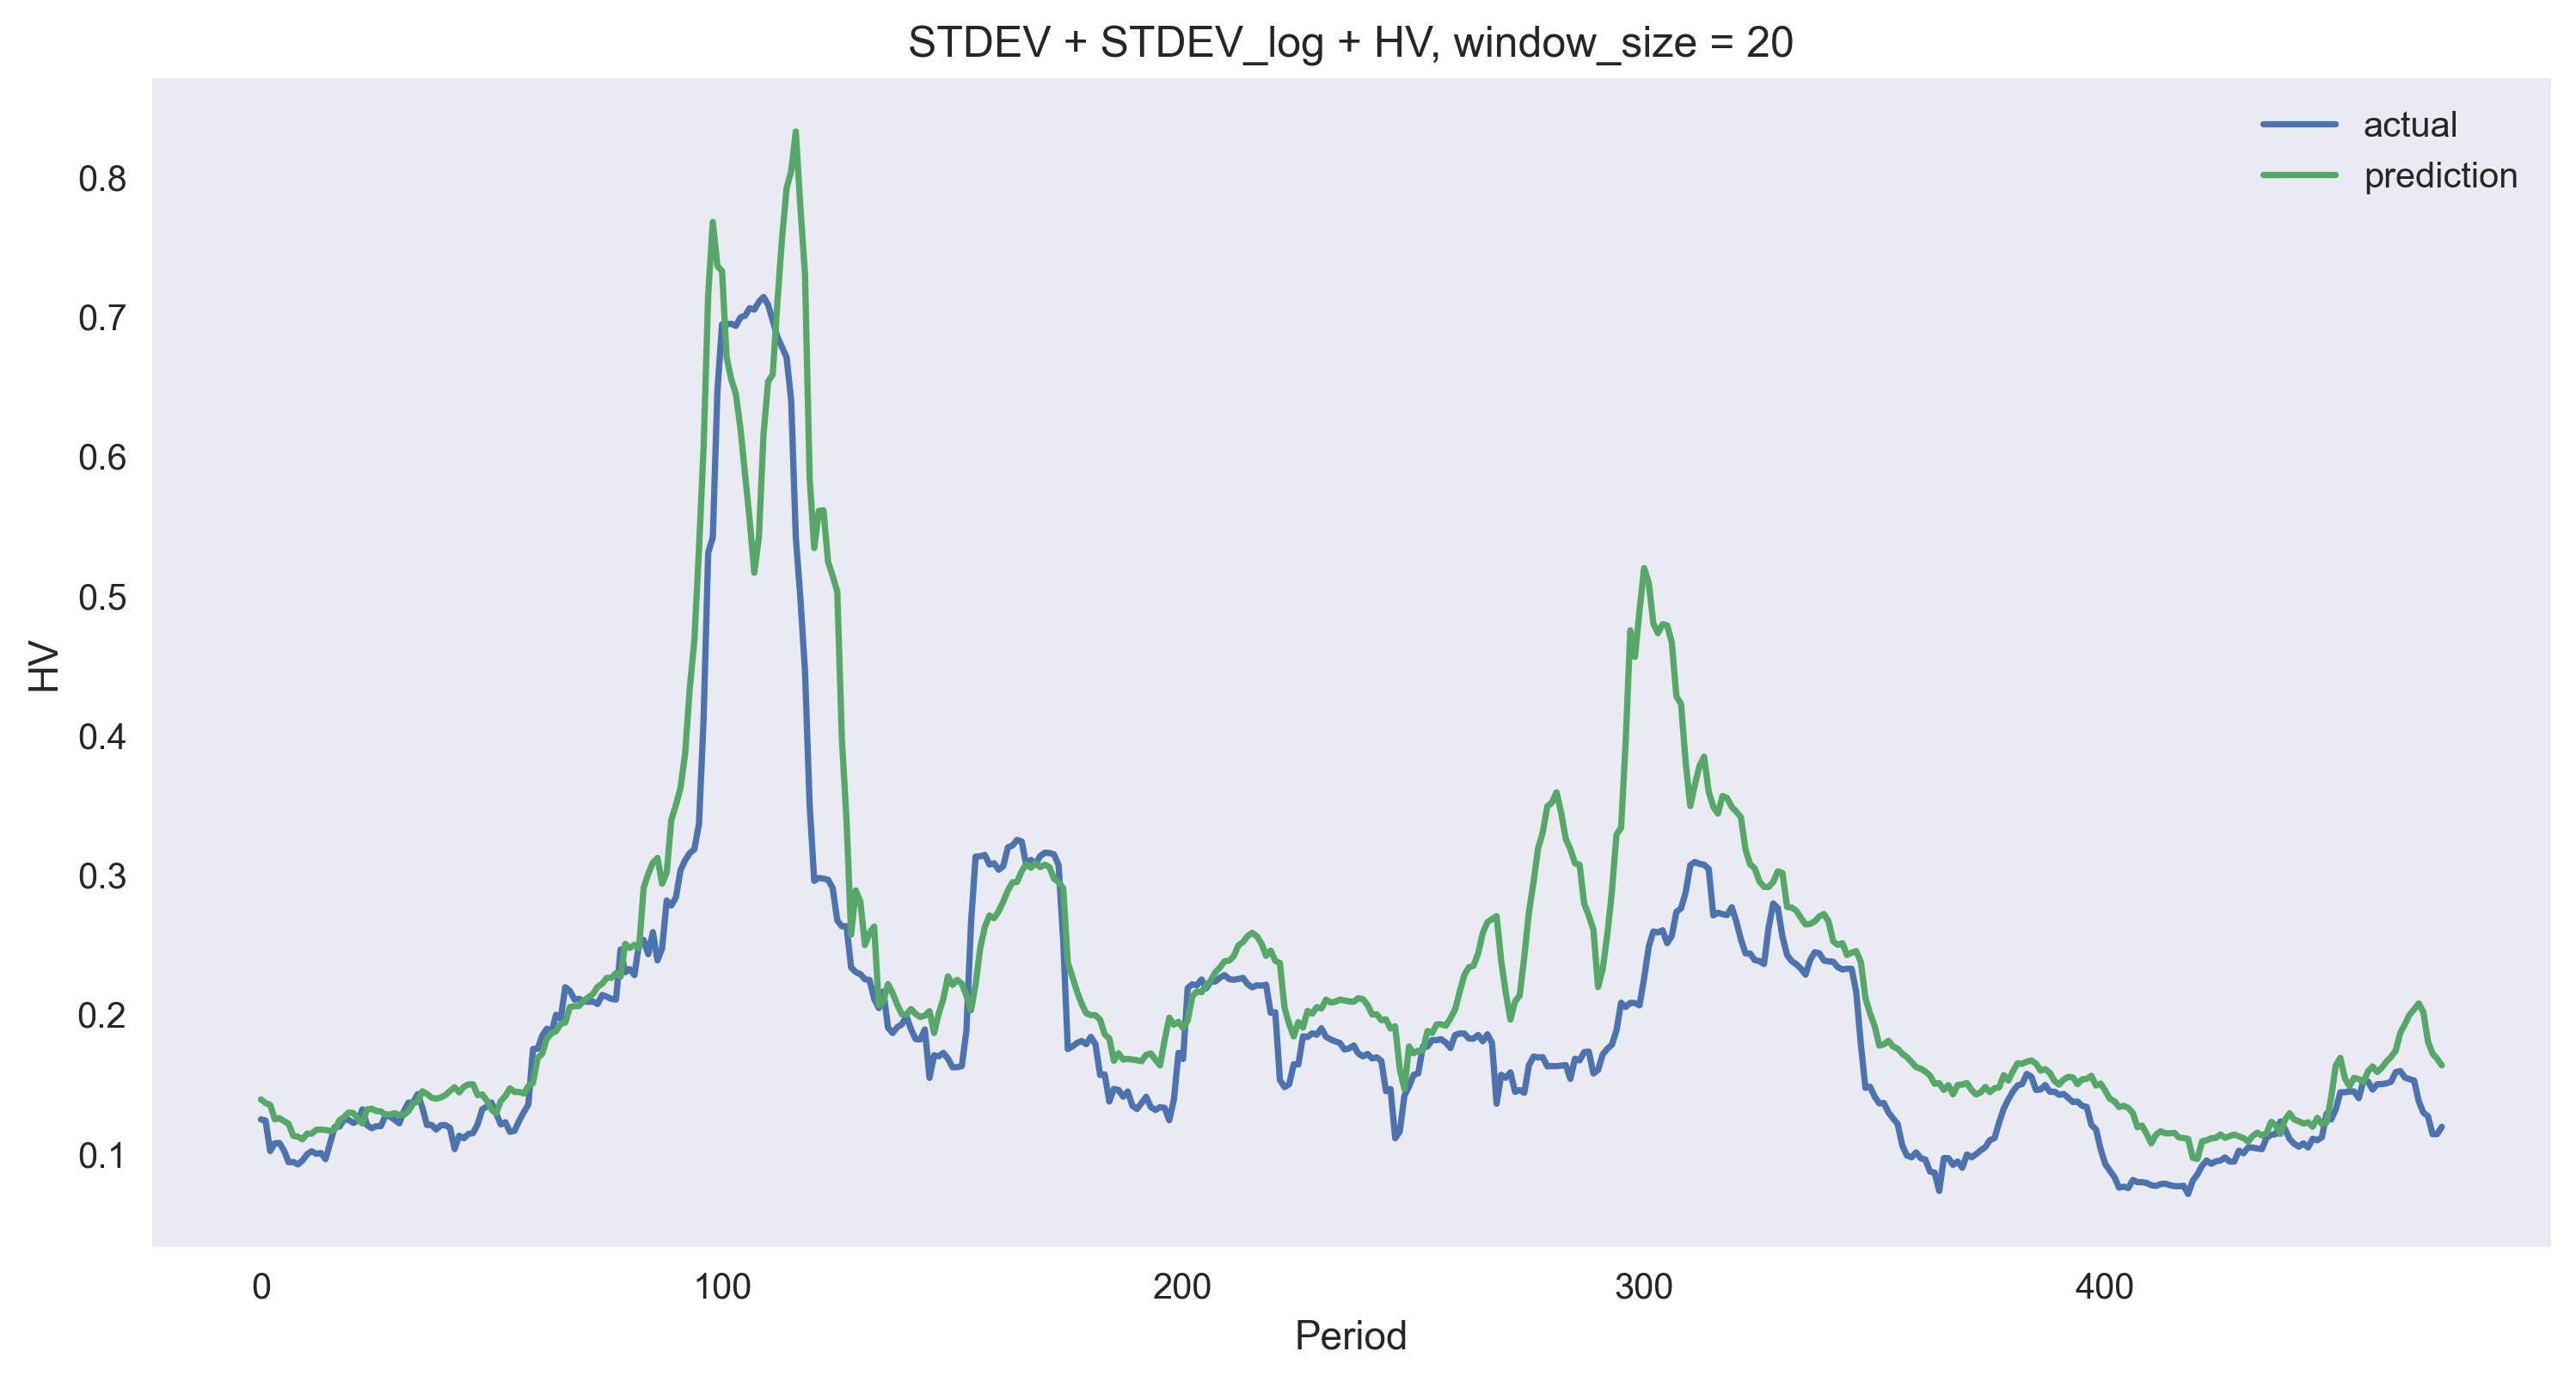

In [24]:
plt.figure(figsize = (12,6))
plt.title('STDEV + STDEV_log + HV, window_size = 20')
plt.ylabel('HV')
plt.xlabel('Period')
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.grid()
plt.legend(loc = 'best')

plt.show()